***
**Tutorial 5 for Chapter 2**

Case study 7: College Attending Plan Modeled by Random Forest
***
<font color = 'darkred'>*Reference:*
<font color = 'darkred'>*Python数据挖掘实战*

<!-- Acknowledgement:  
**i2DM (Tan, Steinbach, Kumar (2018) Introduction to Data Mining , 2nd Ed, Pearson )** Pearson Press   -->
For the course AMA546 Statistical Data Mining   
Lecturer: Dr. Catherine Liu    
AMA, PolyU, HKSAR

In [96]:
import pandas
import numpy as np
from sklearn.preprocessing import OneHotEncoder # Import one-hot encoder
from scipy.sparse import hstack # Import hstack to stack the data
from sklearn.tree import DecisionTreeClassifier # Import the decision tree classifier
from sklearn.tree import plot_tree # Impor the tree plot module to plot the decision tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt # Import plot module

***Contents***
1. Objectives of the analysis
2. Description of the data
3. Exploratory data analysis (based on original dataset)
  - 3.1 Data quality (No need in our case)
    - 3.1.1 Data Cleaning
    - 3.1.2 Data Validation
    - 3.1.3 Data Transformation
  - 3.2 Marginal variable analysis
    - 3.2.1 Gender
    - 3.2.2 Encourage
  - 3.3 Parent income & lQ
4. Data preprocessing
  - 3.4.1 Split the training and testing set
5. Model building
6. Model comparison
  - 5.1 Accuracy
  - 5.2 Confusion matrices
  - 5.3 ROC curve and AUC
7. Summary report
  - 6.1 Objectives
  - 6.2 Organisation of the data
  - 6.3 Exploratory data analysis:
  - 6.4 Model specification
  - 6.5 Model comparison

# Objectives of the analysis

The case study deals with the college attending plan problem which was previously discussed in **Case Study 1**, where we applied the **Decision Tree** model. In this study, we will utilize the **Random Forest** model, an ensembled version of the Decision Tree model, to make predictions.

# Description of the data 

In [132]:
# Load the data
college = pandas.read_csv('college.csv',engine='python') # Parser engine to use. The C is faster while the python is currently more feature-complete.
college.head()

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
0,4558,male,53900,118,encourage,plan
1,4561,female,24900,87,not encourage,not plan
2,4563,female,65800,93,not encourage,not plan
3,4565,male,11440,117,encourage,plan
4,4567,female,16700,102,not encourage,not plan


#  Exploratory data analysis (based on original dataset)

## Data quality (No need in our case)
Based on the content of last tutorial, we will perform the **[Data Cleaning](https://en.wikipedia.org/wiki/Data_cleansing)**, **[Data Validation](https://en.wikipedia.org/wiki/Data_validation)** and **[Data Transformation](https://en.wikipedia.org/wiki/Data_transformation_(computing))** to check the data quality of the dataset.

### Data Cleaning
 
Our dataset is free of any **`NA`** values and does not require any cleaning in this regard.

In [133]:
# There is no NA data in the dataframe
print(college[college.isna().any(axis=1)])

Empty DataFrame
Columns: [StudentID, Gender, Parent_income, IQ, Encourage, Plan]
Index: []


### Data Validation
Additionally, we need to assess if there are any outliers in the observations. We mainly detect the outliers by the **data description table** below.

**In dataset `college`**, all of the data appears to be within reasonable bounds and no inconsistencies are immediately noticeable.

In [134]:
# Basic statistics of dataset college
college.describe()

,StudentID,Parent_income,IQ
count,8000.00000,8000.000000,8000.000000
mean,4000.50000,40584.017500,99.577750
std,2309.54541,18031.506468,18.923655
min,1.00000,4500.000000,60.000000
25%,2000.75000,29400.000000,90.000000
50%,4000.50000,39330.000000,100.000000
75%,6000.25000,51592.500000,110.000000
max,8000.00000,82390.000000,140.000000


As for **string variables**, as noted in the description of the data, they **take only legal values**. All in all, our data set is pretty clean.

In [135]:
# Aggregate the data
def rstr(df): return df.apply(lambda x: [x.unique()]) # define a function
rstr(college[['Encourage', 'Plan']])

,Encourage,Plan
0,"[encourage, not encourage]","[plan, not plan]"


### Data Transformation

**Random Forest** models can be affected by the **scale of the features**. When features have different scales, the model may give **more weight to features with larger scales**, which can negatively impact the accuracy of the model. In the given dataset of `Parent_income` and `IQ`, the scales of the features are significantly different. For instance, the range of `Parent_income` is much higher than that of `IQ`. To ensure a fair contribution of all features, we need to rescale the data:

In [136]:
from sklearn.preprocessing import StandardScaler

# make a copy of original dataset
college_scl = college.copy()
# extract the feature columns
feature_cols = ["Parent_income", "IQ"]
# train the transformer and fit the data on-the-fly
college_scl[feature_cols] = StandardScaler().fit_transform(college[feature_cols])

In [137]:
college_scl.head()

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
0,4558,male,0.738530,0.973565,encourage,plan
1,4561,female,-0.869866,-0.664699,not encourage,not plan
2,4563,female,1.398528,-0.347616,not encourage,not plan
3,4565,male,-1.616384,0.920717,encourage,plan
4,4567,female,-1.324654,0.128009,not encourage,not plan


In order to perform the Random Forest model on the given dataset, we need to use the **one-hot encoding** we mentioned before for the categorical variables in the dataset. One-hot encoding is a technique to transform categorical variables into numerical data, which is needed for machine learning models to process the data.

In this dataset, the `Gender`, `Encourage`, and `Plan` columns contain categorical variables. The `Gender` column has two categories: `male` and `female`. The `Encourage` and `Plan` columns also have two categories each: `encourage` and `not encourage`, and `plan` and `not plan`, respectively.

In [138]:
# Build an one-hot encoder
oneHotEncoder = OneHotEncoder()
# Train the one-hot encoder to get the transformation of columns that need to be processed by one-hot encoder
oneHotEncoder.fit(college_scl[['Gender', 'Encourage']])
# Transform the data
oneHotData = oneHotEncoder.transform(college_scl[['Gender', 'Encourage']])

After transforming the two columns into one-hot encoding, we need to **merge the one-hot columns with the `Parent_income` and `IQ` columns** by column.

In [140]:
# Combine the data obtained from the one-hot code with the parental income and IQ
x = hstack([
    oneHotData, 
    college_scl.Parent_income.values.reshape(-1, 1), 
    college_scl.IQ.values.reshape(-1, 1)
])
# pandas.DataFrame(x.toarray()[:5])
# The response variable
y = college_scl["Plan"]

## Marginal variable analysis

### Gender
First, the data set is **balanced between men and women**, with slightly fewer men (48.4%) and more women (51.6%). Secondly, in general, 67.6% of high school students do not want to go to college to study. The proportion of male high school students with the intention to study is more, accounting for 36.4% of the male high school students. There are 28.7% of female high school students want to go to college. 
<table><thead><tr><th>Gender</th><th>Total</th></tr></thead><tbody><tr><td>Male</td><td>51.6%</td></tr><tr><td>Female</td><td>48.4%</td></tr></tbody></table>

In [143]:
# Gender
crosstb = pandas.crosstab(index = college['Gender'],
                      columns = college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,not plan,plan
Gender,,
female,71.3%,28.7%
male,63.6%,36.4%
Total,67.6%,32.4%


### Encourage
Overall, 51.7% of parents encourage their children to go to college, while 48.3% do not. Among the high school students encouraged by their parents to go to college, 57.0% of them plan to go to college, which is not very differentiated. But notice that 93.8% of the kids whose parents don't encourage them to go to college have no plans to do so, which is a huge difference. This reminds us that **`Encourage` may be a good variable for predicting** the college attending plan.

<table><thead><tr><th>Encourage</th><th>Total</th></tr></thead><tbody><tr><td>encourage</td><td>51.7%</td></tr><tr><td>not encourage<br></td><td>48.3%</td></tr></tbody></table>

In [142]:
# Encourage plan
crosstb = pandas.crosstab(index = college['Encourage'],
                      columns = college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,not plan,plan
Encourage,,
encourage,43.0%,57.0%
not encourage,93.8%,6.2%
Total,67.6%,32.4%


## Parent income & IQ: 
For `Parent income` and `IQ`, we used **boxplots** to compare the degree to which they rated whether high school students planned to go to college or not. If the two resulting boxplots differ markedly in position (e.g. in terms of the median) for students who plan to go to school and those who don't, the corresponding variable can be deemed relevant. As can be observed from the chart below, in terms of **parental income**, **students who plan to attend** college are significantly **higher** than those who plan not to attend college. Of course, you can see some outliers above the upper whisker of students who plan on not going to college, suggesting that there are a small number of students whose parents have higher incomes who also don't plan on going to college. In terms of **student IQ**, **students who plan to attend** college are **higher** than those who plan not to attend college, but there is some **overlap**.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


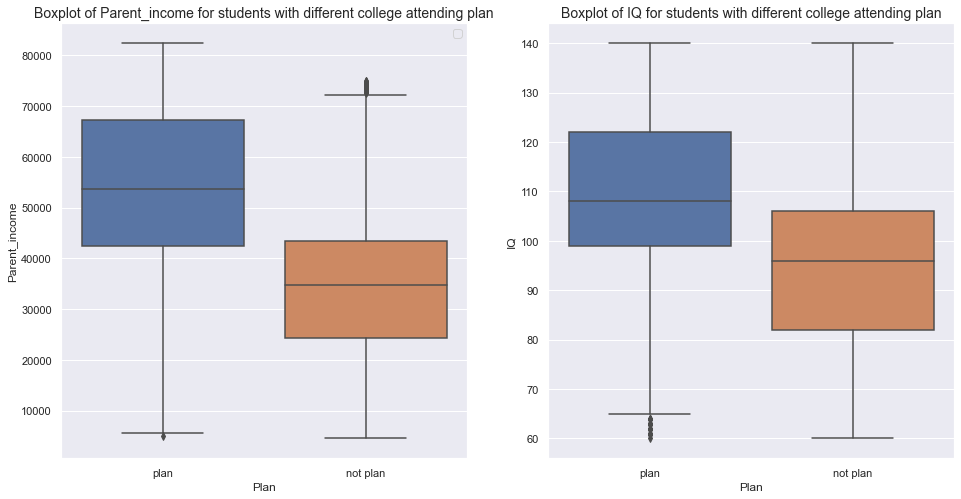

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
# Creation of figure with 2 axis
sns.set(style="ticks")
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Creation of 1st axis
sns.boxplot(x="Plan", y="Parent_income", data=college, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title("Boxplot of Parent_income for students with different college attending plan", fontsize=14)
# Creation of 2nd axis
sns.boxplot(x="Plan", y="IQ", data=college, ax=ax[1])
ax[1].set_title("Boxplot of IQ for students with different college attending plan", fontsize=14)
# Close the empty Figure 2 created by seaborn.
plt.close(2)

## Data preprocessing
The type of the data in the dataset is double, eliminating the need for additional preprocessing. The only required step is to **split the data into training and testing sets**.

### Split the training and testing set

In [153]:
# Split the dataset into training set (70%) and testing set (30%), the random_state is used to control randomness
from sklearn.model_selection import train_test_split # Import the training and testing dataset splitter
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Model building 

**Random Forest** is a popular machine learning algorithm used for both classification and regression tasks. It is an **ensemble learning method** that combines multiple decision trees to make a final prediction.

***Relationship with Decision Trees***

Before we dive into Random Forest, it is important to understand the relationship between **Random Forest** and **Decision Trees**. A Decision Tree splits the dataset into smaller subsets by creating a tree-like structure of decisions and their possible consequences. Each decision tree node represents a question or test about one of the features, and each branch represents the outcome of that test. The final decision is made by following the path from the root to a leaf node.

**Random Forest** works by **combining multiple Decision Trees** to make a final prediction. Each Decision Tree in the Random Forest is **trained on a random subset** of the training data and randomly selected **features**. By doing so, Random Forest can overcome the problem of overfitting that can occur when training a single Decision Tree on the entire dataset.

***Working of Random Forest***

Let's take a look at how Random Forest works step by step. Assume we have a dataset of n samples with m features, and we want to predict a binary outcome variable y. Here are the steps:

1. **Feature sampling:** **Randomly select k features without replacement** from the total m features where k << m. In Random Forest, the value of k is often the square root of m.
2. **Bootstrap aggregating (Bagging):** For each of the k features, create a Decision Tree using a **random subset of n samples**. Sampling is done **with replacement**, which means that a sample can be chosen more than once, leading to the creation of different Decision Trees.
3. **Decision tree growing:** For each feature, **grow a Decision Tree** by recursively splitting the dataset into two subsets based on the optimal split criterion. The optimal split criterion is determined by maximizing the information gain or minimizing the impurity of the split. The Decision Tree **stops growing when the maximum depth is reached or no further improvement in the impurity measure can be achieved**.
4. Repeat steps 1-3 to create a forest of k Decision Trees.

To make a **prediction** on a new sample, pass it through all k Decision Trees, and count the number of times it is classified as a positive outcome. The final prediction is made by taking the **majority vote** of the k Decision Trees. For example, if the sample is classified as positive in 4 out of 5 Decision Trees, the final prediction will be positive.

***Example***

In the illustration below, the dataset comprises of 5 features and 5 observations. Each decision tree in the Random Forest is built using a subset that **randomly** selects 3 features **without replacement** and 5 observations **with replacement**. In subset 1, the features X1, X3, and X4 are selected, and observations 1, 2, and 5 are chosen, with observations 1 and 2 being **selected twice**. The decision trees are grown without pruning, and the final decision is aggregated by **majority voting**.

<img src='https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-030-89010-0_15/MediaObjects/484261_1_En_15_Fig4_HTML.png?as=webp' width=800>

In the analyses below, we use the `GridSearchCV` to find the optimal parameters. The range of the hyperparameters are illustrted.

In [114]:
# Executed duration: 60 second
# Import the RandomForestClassifier module
from sklearn.ensemble import RandomForestClassifier

# Initialize a basic random forest model
rfClassifier = RandomForestClassifier(random_state=1)

# Define a dictionary of hyperparameters to tune
paramGrid = dict(
    max_depth= [5, 6, 7, 8, 9, 10],
    criterion=['gini', 'entropy'],    
    max_leaf_nodes=[10, 11, 12, 13, 14, 15],
    n_estimators=np.arange(10,60,10)
)

# Perform hyperparameter tuning using GridSearchCV with cross-validation
gridSearchCV = GridSearchCV(
    rfClassifier, paramGrid, 
    cv=10, verbose=1, n_jobs=-1,
    return_train_score=True
)

# Fit the model with the data and hyperparameters to find the best combination of hyperparameters
grid = gridSearchCV.fit(x_train, y_train)

# Print the best score and parameters found
print('The optimal score is : %f' % grid.best_score_)
print('The optimal parameters are:')
for key in grid.best_params_.keys():
    print('%s=%s'%(key, grid.best_params_[key]))

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
The optimal score is : 0.837321
The optimal parameters are:
criterion=gini
max_depth=6
max_leaf_nodes=13
n_estimators=50


Using `GridSearchCV`, we find the best model in our search range. The optimal **Accuarcy is 0.8373** and the optimal parameters are (The optimal outcome of cross-validation can potentially differ across multiple runs due to the inherent randomness in the process.):
 - criterion=gini
 - max_depth=6
 - max_leaf_nodes=13
 - n_estimators=50
 
Then, we can train the Random Forest model with optimal parameters:

In [154]:
# Bulid the Random Forest with the optimal parameters
random_forest_opt = RandomForestClassifier(
    criterion='gini',
    max_depth=6, 
    max_leaf_nodes=13,
    n_estimators=50
)
random_forest_opt.fit(x, y)

RandomForestClassifier(max_depth=6, max_leaf_nodes=13, n_estimators=50)

# Model comparison

In this section, we will built the optimal Decision tree model we acquired in the ***Case study 1: College Attending Plan Modeled by Decision Tree*** and compare the optimal Decision Tree model with the Random Forest model in the **testing set**.

In [155]:
# Bulid the Decision Tree with the optimal parameters
decision_tree_opt = DecisionTreeClassifier(
    max_depth=4, 
    max_leaf_nodes=7
)
decision_tree_opt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=7)

## Accuracy

In [156]:
# The Accuracy of Random Forest
random_forest_opt.score(x_test, y_test)

0.85

In [158]:
# The Accuracy of Decision Tree
decision_tree_opt.score(x_test, y_test)

0.84125

The Accuracy for the Random Forest and the Decision Tree on the testing set are **0.8495** and **0.8413** respectively. **The Accuracy of the Random Forest is a little higher**.

## Confusion matrices
We then compare models in terms of the **confusion matrices** obtained on the testing data set. *For detailed introduction of Confusion matrices, see Case study 3.*

In [159]:
# Define a function to calculate the confusion matrix
from sklearn.metrics import confusion_matrix # import confusion matrix module
def calculate_confusion_matrix(y_true, y_pred, labels):
    confu_mat = pandas.DataFrame(confusion_matrix(y_true, y_pred, normalize=None, labels=labels))
    return round(confu_mat, 2)  # formatting the output

In [160]:
# Confusion matrix of Random Forest
calculate_confusion_matrix(y_test, random_forest_opt.predict(x_test), labels=['not plan', 'plan'])

,0,1
0,1475,155
1,205,565


In [161]:
# Confusion matrix of Decision Tree
calculate_confusion_matrix(y_test, decision_tree_opt.predict(x_test), labels=['not plan', 'plan'])

,0,1
0,1495,135
1,246,524


In the presented confusion matrix, the label 0 and 1 correspond to the 'not plan' and 'plan' classes, respectively.  Relative to the Decision Tree method, the Random Forest approach demonstrates superiority by averting $246-204=42$ additional positive samples from being erroneously classified as negative, albeit at the expense of incorrectly assigning $155-135=20$ more negative samples to the positive class.  Given that the correct identification of both positive and negative samples is equally essential to our analysis, **the Random Forest model is deemed to be superior to the Decision Tree method**.

## ROC curve and AUC

Last but not least, we assess the performance of the Decision Tree model and the Random Forest model. *For detail introduction of ROC curve and AUC, see Case study 3*

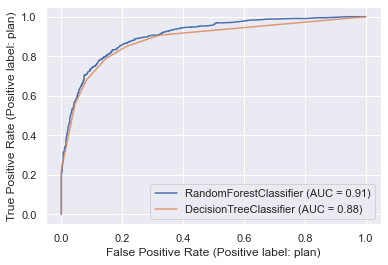

In [162]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

# plot the ROC curve of the Random Forest
roc_random_forest = RocCurveDisplay.from_estimator(random_forest_opt, x_test, y_test)
ax = plt.gca()
# plot the ROC curve of the Decision Tree
roc_decision_tree = RocCurveDisplay.from_estimator(decision_tree_opt, x_test, y_test, ax=ax, alpha=0.8)
plt.show()

Upon analyzing the ROC plot generated, it is evident that the Random Forest model consistently outperforms the Decision Tree model. Specifically, the ROC curve of the Random Forest is almost constantly higher than that of the Decision Tree. And the area under the ROC curve (AUC) of the Random Forest model, calculated to be 0.91, is significantly greater than that of the Decision Tree model. This observation implies that the **Random Forest model** has **superior classification performance** compared to the Decision Tree model.

# Summary report

## Objectives
The case study deals with the college attending plan which was previously discussed in **Case Study 1**, where we applied the **Decision Tree** model. In this study, we will utilize the **Random Forest** model, an ensembled version of the Decision Tree model, to make predictions.


## Organisation of the data
The data set contains a total of 8000 samples. Students use StudentID as a unique identifier. The explanatory variables include the gender of the student, the IQ of the student, the income of the parents, and whether the parents encouraged their children to attend college.

## Exploratory data analysis：
In the course of the exploratory data analysis, we find that `Encourage` has a strong discriminating effect on whether high school students attend college or not. In addition, we also find through the boxplot that `Parent_income` also have a good discrimination effect. After that, we used one-hot encoder to preprocess the data, so that the dataset could be processed by the decision tree model.

##  Model specification
The analysis objective suggested a predictive classification model that allocates high school students to categories with and without plan to go to college. Therefore, we consider **Random Forest**.

## Model comparison
Given that the Random Forest model is an **ensemble** method of the Decision Tree, we aim to build an optimal Decision Tree model based on the findings of Case Study 1: College Attending Plan Modeled by Decision Tree, and compare its performance with that of the Random Forest model on the testing set. By evaluating the **Accuracy** metric, we observe a slightly higher accuracy for the Random Forest model. Furthermore, upon examining the **Confusion Matrices**, we find that the Random Forest model outperforms the Decision Tree method in reducing the type 2 error rate, albeit at the cost of a slight increase in the type 1 error rate. We also observe that the **ROC curve** of the Random Forest model consistently outperforms that of the Decision Tree model, with a correspondingly higher **AUC score**. Overall, we conclude that the **Random Forest model exhibits superior classification performance compared to the Decision Tree model**, which further underscores the utility of ensemble methods in machine learning.